<a href="https://colab.research.google.com/github/Tom-Lennox/Kaggle/blob/master/titanic_20200501.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 【行ったこと】

# ▼ 特徴量エンジニアリング（ohe, replace, map）、sns確認

# ▼ LogisticRegression、RandomForestClassifier　の操作

# ▼ LightGBM

# ▼ ハイパーパラメータの調整

# ▼ Optunaでハイパーパラメータの調整を行う

# ▼ KFold（Cross Validation

# todo:関数化して簡潔にしたい。

In [1]:
# kaggle APIセット
!pip install kaggle

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
# 「Download 100%.」と表示で成功。

# [kaggle.json]を持参する。
from google.colab import drive
drive.mount('/content/drive')

# jsonファイルを指定の場所に配置
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
# titanicをダウンロードします。
!kaggle competitions download -c titanic

# jsonファイルを指定の場所に配置
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
# titanicをダウンロードします。
!kaggle competitions download -c titanic
!ls

Download 100%.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, s

▼ train: 891
▼ test: 418
▼ all_data: 1309
▼ print(all_data.isnull().sum()[all_data.isnull().sum() > 0])
Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64
▼ info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB
None
▼ 確認 [1, 0]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


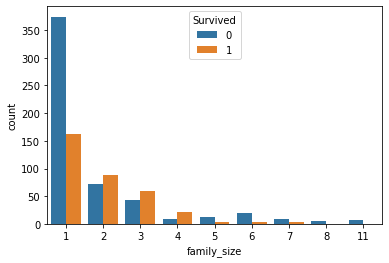

In [0]:
# ▼ 特徴量エンジニアリング（ohe, replace, map）、sns確認
import pandas as pd
import numpy as np

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

train_x = train.drop("Survived",axis=1)
train_y = train["Survived"]
test_x = pd.read_csv("/content/test.csv")

all_data = pd.concat([train, test], sort=False)

# ▲ all_data作成
# ▽ info
all_data.head()

def counter():
  print('▼ train:', len(train))
  print('▼ test:', len(test))
  print('▼ all_data:', len(all_data))
counter()

print('▼ print(all_data.isnull().sum()[all_data.isnull().sum() > 0])')
print(all_data.isnull().sum()[all_data.isnull().sum() > 0])
print('▼ info')
print(all_data.info())
# △ info
# ▼ 置換、fillna等

# # ohe
# all_data = pd.get_dummies(all_data, columns=['Sex'])
# all_data
# # ohe
# map
all_data['Sex'].unique().tolist()
sex_map = {"female":0, "male":1}
all_data['Sex'] = all_data['Sex'].map(sex_map).astype(int)
print('▼ 確認', all_data['Sex'].unique().tolist())
# map
# ohe, map, カラムを分けるか１つで進むか、どちらが良いかよくわからん。

all_data['Embarked'].fillna('None', inplace=True)
all_data['Embarked'].unique()
all_data['Embarked'].replace(['S', 'C', 'Q', 'None'], [0,1,2,3], inplace=True)
all_data['Embarked'].unique()

all_data['Age'].fillna(all_data['Age'].median(), inplace=True)

# ■当たっているかどうか見たいとき ⇒ snsで記載。
import seaborn as sns
all_data['family_size'] = all_data['Parch'] + all_data['SibSp'] + 1
train['family_size'] = all_data['family_size'][:len(train)]
test['family_size'] = all_data['family_size'][len(train):]
sns.countplot(x='family_size', data=train, hue='Survived')
# 集計軸：家族の人数・生存の確認
all_data['is_alone'] = 0
all_data.loc[all_data['family_size'] == 1, 'is_alone'] = 1
train['is_alone'] = all_data['is_alone'][:len(train)]
test['is_alone'] = all_data['is_alone'][:len(train)]
# ▲ 

# ▲ 特徴量エンジニアリング（ohe, replace, map）、sns確認

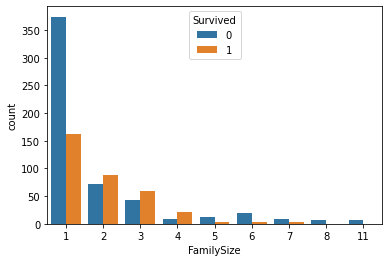

In [0]:
# ▼  LogisticRegression、RandomForestClassifier　の操作

import pandas as pd
import numpy as np

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
gender_submission = pd.read_csv("/content/gender_submission.csv")

data = pd.concat([train, test], sort=False)

# 特徴量エンジニアリング
# 1. Pclass
# 2. Sex
data['Sex'].replace(['male','female'], [0, 1], inplace=True)
# 3. Embarked
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
# 4. Fare
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
# 5. Age
age_avg = data['Age'].mean()
age_std = data['Age'].std()
# add
import seaborn as sns
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]
sns.countplot(x='FamilySize', data=train, hue='Survived')

data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1
train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

# data['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)
data['Age'].fillna(data['Age'].median(), inplace=True)
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)
X_test = test.drop('Survived', axis = 1)

# # 機械学習アルゴリズム
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(penalty='l2', solver='sag', random_state=0)
# # seed固定
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# y_pred[:20]
# # LogisticRegression

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# RandomForestClassifier

sub = gender_submission
sub['Survived'] = list(map(int, y_pred))
sub.to_csv("submission.csv", index=False)

# X_test
# y_pred
# submission = pd.DataFrame({
#   "PassengerId": X_test["PassengerId"],
#   "Survived": y_pred
# })
# submission.to_csv('result.csv', index=False)     
# files.download('result.csv')

# ▲  LogisticRegression、RandomForestClassifier　の操作

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.504316	valid_1's binary_logloss: 0.530963
[20]	training's binary_logloss: 0.426251	valid_1's binary_logloss: 0.480639
[30]	training's binary_logloss: 0.378107	valid_1's binary_logloss: 0.457399
[40]	training's binary_logloss: 0.349982	valid_1's binary_logloss: 0.445422
[50]	training's binary_logloss: 0.327118	valid_1's binary_logloss: 0.439994
[60]	training's binary_logloss: 0.305955	valid_1's binary_logloss: 0.435315
[70]	training's binary_logloss: 0.287936	valid_1's binary_logloss: 0.436188
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.305955	valid_1's binary_logloss: 0.435315
# ▼ y_pred[:10] [0.04097968 0.51889148 0.12140284 0.08425744 0.56370681 0.24560397
 0.70457171 0.14855399 0.74187049 0.04222311]
# ▼ 【修正後】y_pred[:10] [0 1 0 0 1 0 1 0 1 0]


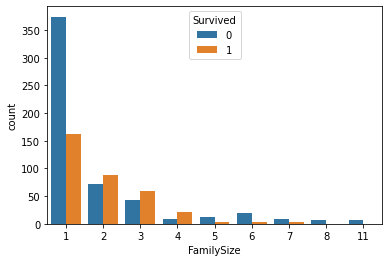

In [0]:
# ▼ LightGBM

import pandas as pd
import numpy as np

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
gender_submission = pd.read_csv("/content/gender_submission.csv")

data = pd.concat([train, test], sort=False)

# 特徴量エンジニアリング
# 1. Pclass

# 2. Sex
data['Sex'].replace(['male','female'], [0, 1], inplace=True)
# 3. Embarked
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
# 4. Fare
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
# 5. Age
age_avg = data['Age'].mean()
age_std = data['Age'].std()
# add
import seaborn as sns
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]
sns.countplot(x='FamilySize', data=train, hue='Survived')

data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1
train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

data['Age'].fillna(data['Age'].median(), inplace=True)
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)
X_test = test.drop('Survived', axis = 1)

# ▽ LightGBM
# 機械学習アルゴリズム
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)
# train, validationに分割

categorical_features = ['Embarked', 'Pclass', 'Sex']
# カテゴリ変数を指図


import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)
# ▽ ハイパーパラメータの調整
params = {
    'objective': 'binary',
    'max_bin': 300,
    'learning_rate': 0.05,
    'num_leaves': 40
}
# △ ハイパーパラメータの調整
model = lgb.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10,
                  num_boost_round=1000,
                  early_stopping_rounds=10)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# lgb準備

print('# ▼ y_pred[:10]', y_pred[:10])
y_pred = (y_pred > 0.5).astype(int)
print('# ▼ 【修正後】y_pred[:10]', y_pred[:10])
# .5を超えたら1とする。

# 
# △ LightGBM

# 提出
sub = gender_submission
sub['Survived'] = list(map(int, y_pred))
sub.to_csv("submission.csv", index=False)
# ▲ LightGBM

     |████████████████████████████████| 184kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 8.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 112kB 16.9MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=b8a8fca6f7e6756fa28f49ad78ceb2e05dd304650cc52974797068ad8b183e3b
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
ERROR: Operation cancelled by user


ModuleNotFoundError: ignored

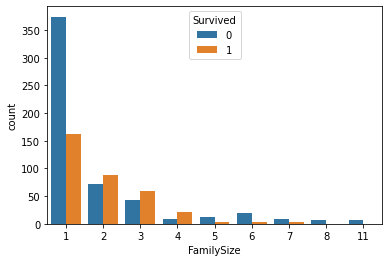

In [0]:
# ▼ Optunaでハイパーパラメータの調整を行う

import pandas as pd
import numpy as np

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
gender_submission = pd.read_csv("/content/gender_submission.csv")

data = pd.concat([train, test], sort=False)

# 特徴量エンジニアリング
# 1. Pclass
# 2. Sex
data['Sex'].replace(['male','female'], [0, 1], inplace=True)
# 3. Embarked
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
# 4. Fare
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
# 5. Age
age_avg = data['Age'].mean()
age_std = data['Age'].std()
# add
import seaborn as sns
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]
sns.countplot(x='FamilySize', data=train, hue='Survived')

data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1
train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

data['Age'].fillna(data['Age'].median(), inplace=True)
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)
X_test = test.drop('Survived', axis = 1)

# ▼ LightGBM
# 機械学習アルゴリズム
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)
# train, validationに分割

categorical_features = ['Embarked', 'Pclass', 'Sex']
# カテゴリ変数を指図


import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)
# ▼ ハイパーパラメータの調整
!pip install optuna

import optuna
from sklearn.metrics import log_loss

def objective(trial):
    params = {
        'objective': 'binary',
        'max_bin': trial.suggest_int('max_bin', 255, 500),
        'learning_rate': 0.05,
        'num_leaves': trial.suggest_int('num_leaves', 32, 128),
    }

    lgb_train = lgb.Dataset(X_train, y_train,
                            categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_valid, y_valid,
                           reference=lgb_train,
                           categorical_feature=categorical_features)

    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)

    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    score = log_loss(y_valid, y_pred_valid)
    return score

study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)
study.best_params 

# ▽ 返り値。
# {'max_bin': 427, 'num_leaves': 79}
# なんだか凄い技術だ。

# ▽ 表示された最良のハイパーパラメータを使用
params = {
    'objective': 'binary',
    'max_bin': 427,
    'num_leaves': 79,
    'learning_rate': 0.05,
}
# ▲ ハイパーパラメータの調整
model = lgb.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10,
                  num_boost_round=1000,
                  early_stopping_rounds=10)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# lgb準備

print('# ▼ y_pred[:10]', y_pred[:10])
y_pred = (y_pred > 0.5).astype(int)
print('# ▼ 【修正後】y_pred[:10]', y_pred[:10])
# .5を超えたら1とする。

# 
# ▲ LightGBM

# 提出
sub = gender_submission
sub['Survived'] = list(map(int, y_pred))
sub.to_csv("submission.csv", index=False)
# ▲ Optunaでハイパーパラメータの調整を行う

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.508041	valid_1's binary_logloss: 0.516557
[20]	training's binary_logloss: 0.429965	valid_1's binary_logloss: 0.447932
[30]	training's binary_logloss: 0.385942	valid_1's binary_logloss: 0.412737
[40]	training's binary_logloss: 0.358105	valid_1's binary_logloss: 0.394345
[50]	training's binary_logloss: 0.333619	valid_1's binary_logloss: 0.387815
[60]	training's binary_logloss: 0.311334	valid_1's binary_logloss: 0.387029
[70]	training's binary_logloss: 0.293771	valid_1's binary_logloss: 0.381019
[80]	training's binary_logloss: 0.276607	valid_1's binary_logloss: 0.376464
[90]	training's binary_logloss: 0.261473	valid_1's binary_logloss: 0.371518
[100]	training's binary_logloss: 0.249575	valid_1's binary_logloss: 0.370019
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.250771	valid_1's binary_logloss: 0.369738
99
Training until validation scores don't improve for 10 rounds.
[

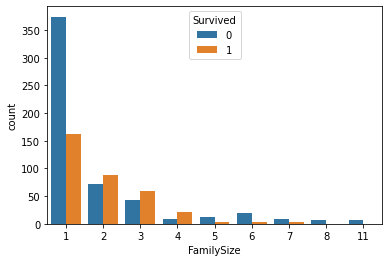

In [32]:
# ▼ KFold（Cross Validation
import pandas as pd
import numpy as np

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
gender_submission = pd.read_csv("/content/gender_submission.csv")

data = pd.concat([train, test], sort=False)

# 特徴量エンジニアリング
# 1. Pclass
# 2. Sex
data['Sex'].replace(['male','female'], [0, 1], inplace=True)
# 3. Embarked
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
# 4. Fare
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
# 5. Age
age_avg = data['Age'].mean()
age_std = data['Age'].std()
# add
import seaborn as sns
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]
sns.countplot(x='FamilySize', data=train, hue='Survived')

data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1
train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

data['Age'].fillna(data['Age'].median(), inplace=True)
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)
X_test = test.drop('Survived', axis = 1)

# ▽ KFold（Cross Validation
import lightgbm as lgb
from sklearn.model_selection import KFold
# KFold -> 交差検証。trainをn分割して1つをtestとして使用する。
kf = KFold(n_splits=5, shuffle=True, random_state=0)
# 5分割。

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
# 0で初期化
cv = KFold(n_splits=5, shuffle=True, random_state=0)
# 5分割。上記kfと同一。

categorical_features = ['Embarked', 'Pclass', 'Sex']
# カテゴリ変数のカラム

params = {
    'objective': 'binary',
    'max_bin': 300,
    'learning_rate': 0.05,
    'num_leaves': 40
}
# LightGBMのparamを設定

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
  # print(fold_id, train_index)
  # ▽ 定形と心得る。
  X_tr = X_train.loc[train_index, :]
  X_val = X_train.loc[valid_index, :]
  y_tr = y_train[train_index]
  y_val = y_train[valid_index]

  lgb_train = lgb.Dataset(X_tr, y_tr,
                          categorical_feature=categorical_features)
  lgb_eval = lgb.Dataset(X_val, y_val,
                         reference=lgb_train,
                         categorical_feature=categorical_features)

  model = lgb.train(params, lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    verbose_eval=10,
                    num_boost_round=1000,
                    early_stopping_rounds=10)
  print(model.best_iteration)
  oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
  y_pred = model.predict(X_test, num_iteration=model.best_iteration)

  y_preds.append(y_pred)
  models.append(model)
  # △ 
# △ KFold（Cross Validation
# ▲ KFold（Cross Validation


In [0]:
print(X_train)
print('# ▼', X_valid)

     Pclass  Sex   Age     Fare  Embarked  FamilySize  IsAlone
111       3    1  14.5  14.4542         1           2        0
722       2    0  34.0  13.0000         0           1        1
765       1    1  51.0  77.9583         0           2        0
626       2    0  57.0  12.3500         2           1        1
757       2    0  18.0  11.5000         0           1        1
..      ...  ...   ...      ...       ...         ...      ...
164       3    0   1.0  39.6875         0           6        0
288       2    0  42.0  13.0000         0           1        1
208       3    1  16.0   7.7500         2           1        1
889       1    0  26.0  30.0000         1           1        1
424       3    0  18.0  20.2125         0           3        0

[623 rows x 7 columns]
# ▼      Pclass  Sex   Age      Fare  Embarked  FamilySize  IsAlone
886       2    0  27.0   13.0000         0           1        1
844       3    0  17.0    8.6625         0           1        1
142       3    1  24.0  

In [0]:
# kaggle submit
!kaggle competitions submit titanic -f submission.csv -m "test"

100% 2.77k/2.77k [00:00<00:00, 9.02kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster